In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

# Gravity Model Inspired Neural Network (FC)

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [49]:
# Model specification
class DeepGravityNet(nn.Module):
    def __init__(self, inp_dim, hid_dim=256, out_dim=1, dropout_p=0.35):
        super(DeepGravityNet, self).__init__()
        
        self.deep_graivty_fc1 = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.deep_graivty_fc2 = nn.Sequential(
            
            nn.Linear(hid_dim, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, inp_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        self.out_fc = nn.Sequential(
            nn.Linear(inp_dim, 1),
            nn.ReLU()
        )
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        y = self.deep_graivty_fc1(x)
        y = nn.BatchNorm1d(y.shape[1], device=device)(y)
        # shape of "x" here = [batchsize, sequence_len, 256]
        y = self.deep_graivty_fc2(y)
        y += x
        y = self.out_fc(y)
        return y
    

## Reading data 

In [50]:
OD = pd.read_csv('./data/OD.csv', index_col=0)
data_X_org = pd.read_csv('./data/data_X.csv', index_col=0)
connectivity = pd.read_csv('./data/connectivity.csv', index_col=0)
stops = pd.read_csv('./data/stops_order.csv', index_col=0)


In [51]:
def get_data_X(dest):
    data_X_df = data_X_org.copy()
    # dest means the destination station name
    dest_data = data_X_df.loc[data_X_df['nearest station']==dest]
    dest_lat = data_X_df.loc[data_X_df['nearest station']==dest, 'INTPTLAT'].values
    dest_lon = data_X_df.loc[data_X_df['nearest station']==dest, 'INTPTLON'].values
    
    dist_lst = []
    for i in data_X_df.index:
        lat = data_X_df.loc[i, 'INTPTLAT']
        lon = data_X_df.loc[i, 'INTPTLON']
        dist = np.sqrt((dest_lat-lat)**2 + (dest_lon-lon)**2) * 111  # km
        dist_lst.append(dist[0])
    
    data_X_df.insert(2, 'dist', dist_lst)
    
    data_X_df = data_X_df.drop(['INTPTLAT', 'INTPTLON', 'nearest station'], axis=1)
    data_X = data_X_df.to_numpy()
    
    dest_data = dest_data.drop(['INTPTLAT', 'INTPTLON', 'nearest station'], axis=1)
    dest_data = dest_data.to_numpy().reshape(1, -1)
    dest_data_mat = np.repeat(dest_data, data_X.shape[0], axis=0)
    
    # concatenate data_X and dest_data_mat
    data_X = np.concatenate([data_X, dest_data_mat], axis=1)
    
    # normalize
#     data_X = (data_X) / (data_X.max(axis=0))
        
    return data_X

In [52]:
def get_data_X_for_all_stops(stops):
    # stops should be a list
    data_X = get_data_X(stops[0])
    data_y = OD.loc[:, stops[0]].to_numpy().reshape(-1, 1)
    data_y = (data_y - data_y.min())/(data_y.max() - data_y.min())
    
    for i in stops[1:]:
        data_X = np.concatenate([data_X, get_data_X(i)], axis=0)
        
        y = OD.loc[:, i].to_numpy().reshape(-1, 1)
        y = (y - y.min())/(y.max() - y.min())
        data_y = np.concatenate([data_y, y], axis=0)
        
    return data_X, data_y

In [53]:
data_X, data_y = get_data_X_for_all_stops(list(stops['stop']))
print(data_X.shape)
print(data_y.shape)

(2500, 37)
(2500, 1)


In [54]:
# Initialization of hyper parameters
inp_dim = data_X.shape[-1]
print('Input dimension is %i'%inp_dim)

Input dimension is 37


## Train the model

In [55]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop = 0.7
l = int(data_X.shape[0]*prop)

X_train = torch.tensor(data_X[:l, :], dtype=torch.float32).to(device)
y_train = torch.tensor(data_y[:l, :], dtype=torch.float32).to(device)
X_val = torch.tensor(data_X[l:, :], dtype=torch.float32).to(device)
y_val = torch.tensor(data_y[l:, :], dtype=torch.float32).to(device)

batch_size = 2500
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)


In [56]:
# Train the model by inputing 
# [land use data and trip data (demand at each region)] 
# to the model, then output one column of OD
model = DeepGravityNet(inp_dim).to(device)
loss_func = nn.MSELoss()
loss_set_train = []
loss_set_val = []


In [57]:
optimizer = optim.Adam(model.parameters())

In [58]:
model.train()

epochs = 1000

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        out_val = model(X_val)
#         ipdb.set_trace()
        loss_val = loss_func(out_val, y_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0 success, val loss:0.216881, train loss:0.241633
Epoch 50 success, val loss:0.032213, train loss:0.031734
Epoch 100 success, val loss:0.037931, train loss:0.024780
Epoch 150 success, val loss:0.045754, train loss:0.019484
Epoch 200 success, val loss:0.037407, train loss:0.015870
Epoch 250 success, val loss:0.033871, train loss:0.013350
Epoch 300 success, val loss:0.035685, train loss:0.010656
Epoch 350 success, val loss:0.029729, train loss:0.009968
Epoch 400 success, val loss:0.032649, train loss:0.008015
Epoch 450 success, val loss:0.038895, train loss:0.007688
Epoch 500 success, val loss:0.035445, train loss:0.006493
Epoch 550 success, val loss:0.034953, train loss:0.005778
Epoch 600 success, val loss:0.031858, train loss:0.005272
Epoch 650 success, val loss:0.034819, train loss:0.005375
Epoch 700 success, val loss:0.034024, train loss:0.004734
Epoch 750 success, val loss:0.033080, train loss:0.005046
Epoch 800 success, val loss:0.035561, train loss:0.004799
Epoch 850 success

In [59]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

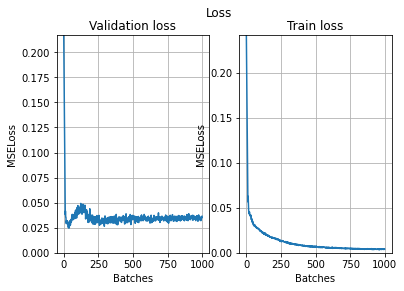

In [60]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

## Test the model

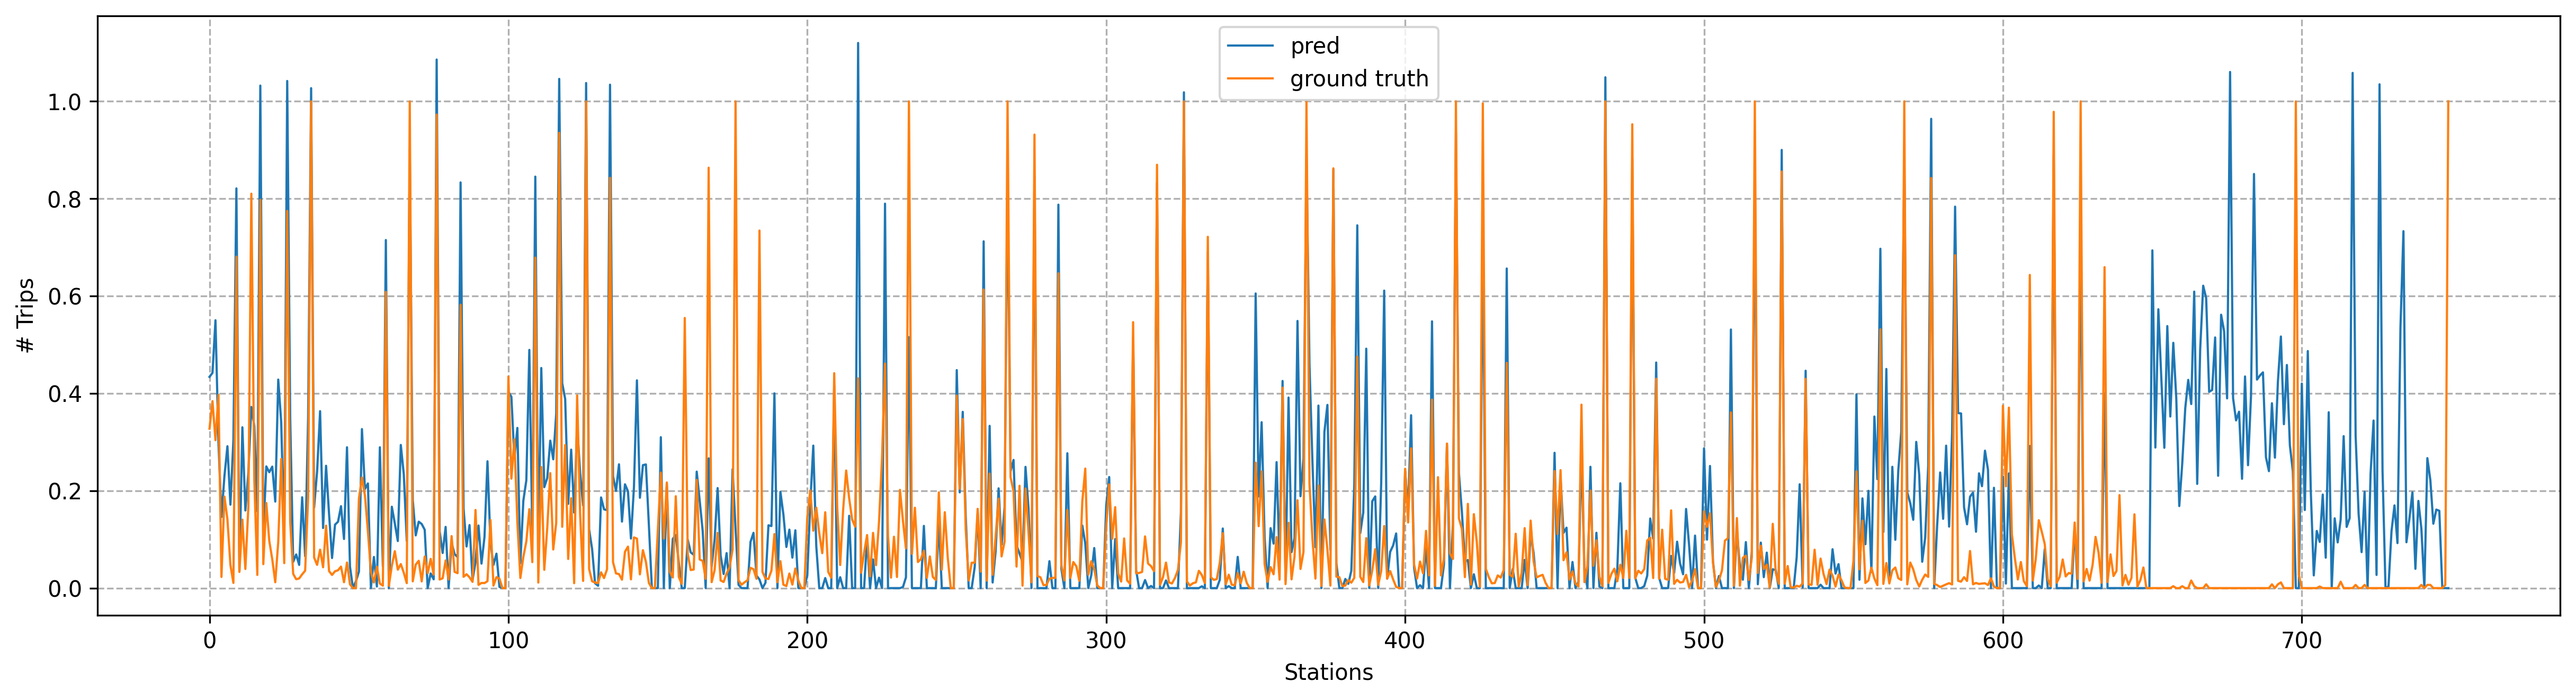

In [63]:
plt.figure(figsize=[20,5], dpi=300)
plt.plot(out_val.cpu().detach().numpy()[:, 0], label='pred', lw=1)
plt.plot(y_val.cpu().detach().numpy()[:, 0], label='ground truth', lw=1)
plt.xlabel('Stations')
plt.ylabel('# Trips')
plt.legend()
plt.grid(ls='--')

In [ ]:
# Input the data from the Bay area to evaluate
# whether the model is preactical